In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

## Data processing

In [3]:
train_df = pd.read_csv('archive/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')

y_train = torch.from_numpy(train_df['label'].to_numpy())
train_df = train_df.drop('label', axis = 1)

X_train = torch.from_numpy(train_df.to_numpy())

y_test = torch.from_numpy(test_df['label'].to_numpy())
test_df = test_df.drop('label', axis = 1)

X_test = torch.from_numpy(test_df.to_numpy())

In [4]:
new_size = 64

In [5]:
resize = transforms.Compose([transforms.Resize(size=(new_size,new_size), antialias=True)])

X_train_res = resize(X_train.view(len(X_train),1,28,28))
X_test_res = resize(X_test.view(len(X_test),1,28,28))

In [6]:
X_train_res = X_train_res.view(-1, new_size*new_size)
X_test_res = X_test_res.view(-1, new_size*new_size)

In [7]:
data_transform = transforms.Compose([
    #transforms.RandomResizedCrop(new_size, scale=(0.90,1), antialias=True),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.1), scale=(1, 1)),
    #transforms.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.RandomRotation(degrees=10),
    ])


In [8]:
aug_ratio = 2
X_train_aug = X_train_res
y_train_aug = y_train

for a in range(aug_ratio):
    aug = data_transform(X_train_res.view(len(X_train),1,new_size,new_size))
    tmp = aug.view(len(X_train_res),new_size*new_size)
    X_train_aug = torch.cat((X_train_aug,tmp), dim=0)
    y_train_aug = torch.cat((y_train_aug,y_train), dim=0)

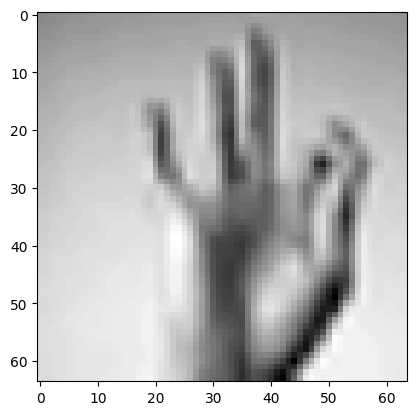

In [9]:
col = transforms.ColorJitter(brightness=0.6, contrast=0.5, saturation=0.5, hue=0.3)(X_test_res[1].view(1,64,64))
plt.imshow(col.view(64,64), cmap='gray')

## Visualize and Normalize data

In [10]:
def ImgShow(i, X, y, test=False):
    if not test:

        plt.imshow(X[i].view(64,64), cmap='gray')
        lab = string.ascii_uppercase[y[i]]
        plt.title(f'Image n.{i},  label: {lab}')
        plt.show()

    else:

        plt.imshow(X[i].view((64,64)), cmap='gray')
        pred = string.ascii_uppercase[torch.argmax(cnn(X[i].view(1,1,64,64)))]
        lab = string.ascii_uppercase[y[i]]
        plt.title(f'Image n.{i}, true label: {lab}, pred labe: {pred}')
        plt.show() 

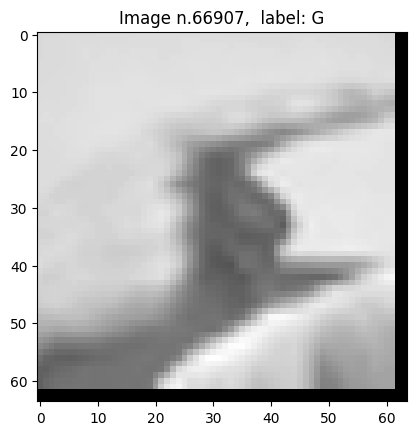

In [11]:
ImgShow(torch.randint(low=0,high=len(X_train_aug), size=(1,)).item(), X_train_aug, y_train_aug)  

In [12]:
def Normalize(X):
    mean = X.float().mean(dim=1, keepdim= True)
    std = X.float().std(dim=1, keepdim= True)
    return (X - mean)/std

In [13]:
X_train_norm = Normalize(X_train_aug)
X_test_norm = Normalize(X_test_res)

train_size = int(0.9*len(X_train_aug))
X_val, y_val = X_train_norm[train_size:],  y_train_aug[train_size:]

X_train_norm, y_train = X_train_norm[:train_size], y_train_aug[:train_size]

## Definition of the model

In [14]:
class ASL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(2048 ,128)
        self.batchnormL = nn.BatchNorm1d(128)
        self.out = nn.Linear(128,25)
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)) + self.drop(x))
        x = self.maxpool(F.relu(self.conv2(x)) + self.drop(x)) 
        x = self.maxpool(F.relu(self.conv3(x)) + self.drop(x)) 
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) 
        x = self.drop(x)
        x = self.batchnormL(x)
        x = self.out(x)
        
        return x
    
class ASL_CNN_resize(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(7,7), padding=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(9,9), padding=4)
        #self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(9,9), padding=4)
        self.maxpool3 = nn.MaxPool2d(3,3)
        self.fc1 = nn.Linear(64 ,256)
        self.batchnormC = nn.BatchNorm2d(16)
        self.batchnormL = nn.BatchNorm1d(256)
        self.out = nn.Linear(256,25)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.maxpool3(self.batchnormC(F.relu(self.conv1(x)) + self.drop(x)))
        x = self.batchnormC(x)
        x = self.maxpool3(self.batchnormC(F.relu(self.conv2(x)) + self.drop(x)))
        x = self.batchnormC(x) 
        x = self.maxpool3(self.batchnormC(F.relu(self.conv3(x)) + self.drop(x)))
       # x = self.maxpool3(F.relu(self.conv4(x)) + self.drop(x)) 
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) 
        x = self.drop(x)
        x = self.batchnormL(x)
        x = self.out(x)
        
        return x

cnn = ASL_CNN_resize().to(device)

print('The model has', sum(p.numel() for p in cnn.parameters() if p.requires_grad), 'trainable parameters' )

The model has 57337 trainable parameters


In [15]:
CELoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.3, total_iters=1000)

## Training procedure

In [16]:
gen = torch.manual_seed(123)

batch = 32
loss_eval = 800
tot_epochs = 1

for epoch in range(tot_epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    for i in range(len(X_train_norm)//batch):
        
        # Batch of training 
        ix = torch.randint(0, len(X_train_norm), (batch,1), generator=gen)
        ixv = torch.randint(0, len(X_val), (batch,1), generator=gen)
        
        #
        cnn.train()
        out = cnn(X_train_norm[ix].view(batch,1,new_size,new_size).to(device))
        loss = CELoss(out, y_train_aug[ix].view(batch).to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cnn.eval()
        with torch.no_grad():
            out = cnn(X_val[ixv].view(batch,1,new_size,new_size).to(device))
            loss_val = CELoss(out, y_val[ixv].view(batch).to(device))
            running_val_loss += loss_val.item()
            running_loss += loss.item() 

        scheduler.step()


        if i % loss_eval == loss_eval-1:
            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss={running_loss/loss_eval:.5f} || val loss={running_val_loss/loss_eval:.5f}')
            running_loss = 0.0
            running_val_loss = 0.0

(epoch: 0), sample: 25600, ---> train loss=0.69275 || val loss=1.01296
(epoch: 0), sample: 51200, ---> train loss=0.08177 || val loss=0.27086


## Model's accuracy evaluation

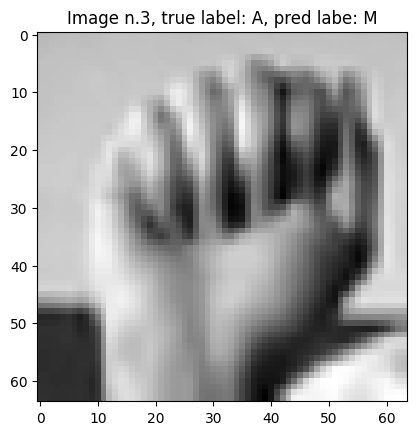

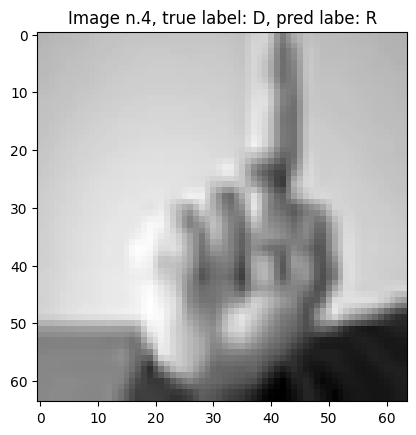

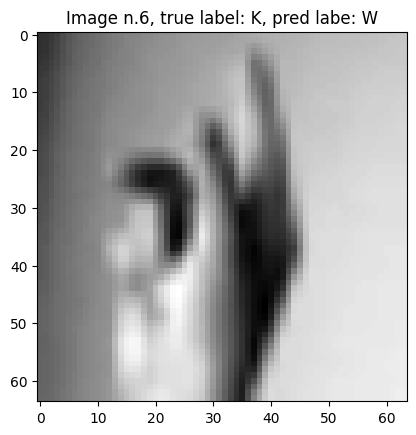

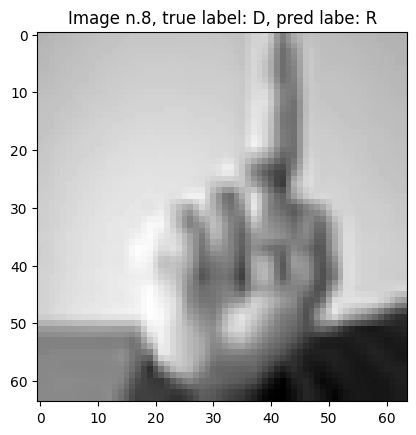

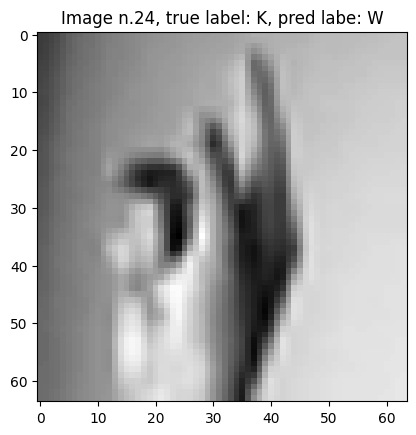

Test Accuracy of the model on test images: 87.771891%


In [17]:
cnn.eval()  
correct = 0
j = 0

cnn.to('cpu')

for i in range(len(X_test_norm)):
    image = X_test_norm[i]
    label = y_test[i]
    out = cnn(image.view(1,1,new_size,new_size))
    pred = torch.argmax(out)
    if pred == label:
        correct += 1
    else:
        if j < 5:
            ImgShow(i, X_test_norm, y_test, True)
            j += 1
        

print('Test Accuracy of the model on test images: %.6f%%' % (100.0*correct/len(y_test)))

In [18]:
HLT

NameError: name 'HLT' is not defined

In [177]:
import cv2 
import mediapipe as mp

img_set = []

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

font = cv2.FONT_HERSHEY_SIMPLEX
capture = cv2.VideoCapture(0)

offset = 150

if not capture.isOpened():
    exit(0)
while True:
    ret, frame = capture.read()
    
    frame = cv2.flip(frame, 1)
    results = hands.process(frame)

    # Check if hands are detected
    if results.multi_hand_landmarks:
        for landmarks in results.multi_hand_landmarks:
            # Convert normalized hand landmarks to pixel coordinates
            h, w, _ = frame.shape
            hand_landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks.landmark]

            # Get bounding box coordinates
            x_min, y_min = min(hand_landmarks, key=lambda x: x[0])[0]-offset, min(hand_landmarks, key=lambda x: x[1])[1]-offset
            x_max, y_max = max(hand_landmarks, key=lambda x: x[0])[0]+offset, max(hand_landmarks, key=lambda x: x[1])[1]+offset

            # Draw a rectangle around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            #print(x_min,x_max,y_min,y_max)

            frame_hand = frame[y_min:y_max, x_min:x_max]
    
            img = cv2.resize(cv2.cvtColor(frame_hand, cv2.COLOR_BGR2GRAY), (64,64))
            if len(img_set) < 200:
                img_set.append(img)
            else:
                cv2.putText(frame,  
                    'Acquisition Done',  
                    (50, 220),  
                    font, 4,  
                    (0, 0, 255),  
                    4,  
                    cv2.LINE_4)
                if cv2.waitKey(1) == ord('q'):
                        break  

            frame_cnn = transforms.ToTensor()(img)
            letter = string.ascii_uppercase[torch.argmax(cnn(frame_cnn.view(1,1,64,64)))]

            cv2.putText(frame,  
                    'letter',  
                    (50, 220),  
                    font, 4,  
                    (0, 0, 255),  
                    4,  
                    cv2.LINE_4)  
            cv2.imshow('Hand Crop', img)   
            
    cv2.imshow('American Sign Language', frame)
    
    if cv2.waitKey(1) == ord('q'):
          break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

I0000 00:00:1707067265.650563       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro


-1

In [166]:
capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [178]:
import csv
import numpy as np

# Example list of images
image_list = [np.random.randint(0, 256, size=(28, 28, 1), dtype=int) for _ in range(10)]

# Specify the dimensions of each image
image_height, image_width = img_set[0].shape

# Flatten each image and store in a list
flattened_images = [image.flatten() for image in img_set]

# Create a CSV file
csv_filename = 'personal_dataset.csv'

# Open the CSV file for writing
with open(csv_filename, 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write the header (pixel indices)
    #header = [f'pixel_{i}' for i in range(image_height * image_width)]
    #csv_writer.writerow(['label'] + header)

    # Write the flattened images to the CSV file
    for i, flattened_image in enumerate(flattened_images):
        csv_writer.writerow( np.insert(flattened_image,0,23))

print(f'CSV file "{csv_filename}" created successfully.')

CSV file "personal_dataset.csv" created successfully.


In [189]:
add_df = pd.read_csv('personal_dataset.csv')
#test_df = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')

y_train_add = torch.from_numpy(add_df['label'].to_numpy())
add_df = add_df.drop('label', axis = 1)

X_add = torch.from_numpy(add_df.to_numpy())

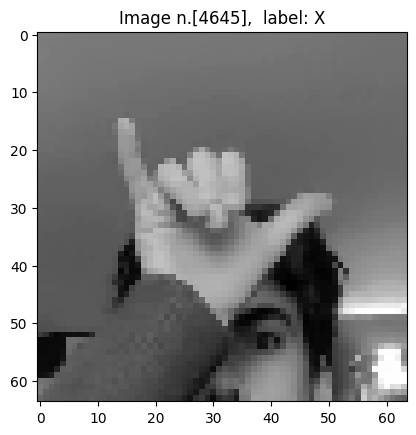

In [181]:
ImgShow([4645],X_add,y_train_add)

In [182]:
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

In [190]:
add_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,129,131,130,131,127,125,121,116,112,108,...,65,66,66,66,66,67,67,67,68,69
1,129,128,130,130,128,125,121,118,114,109,...,65,65,67,67,66,66,67,67,68,68
2,92,127,128,129,128,127,125,121,119,113,...,65,66,67,68,66,67,67,68,66,67
3,81,126,128,128,128,127,126,123,120,115,...,65,66,65,66,66,67,67,67,67,67
4,82,126,127,127,127,127,126,122,119,116,...,65,66,66,67,67,67,66,68,68,68


In [188]:
len(y_train_add)
len(X_add)

4800